In [1]:
# Install the torch package
%pip install torch numpy matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import matplotlib.pyplot as plt

from goyalWelchData import GoyalWelchData
from flexibleMLP import FlexibleMLP
from functions import *

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
goyal_welch_data = GoyalWelchData(input_file='gld_close_prices.csv')
X_train, X_test, y_train, y_test, test_dates = goyal_welch_data.get_train_and_test_data()

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets and DataLoaders for training and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


/tmp/ipykernel_2001/163967974.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.goyal_welch_data['excess_returns'] = self.monthly_returns['GLD'] - self.goyal_welch_data.Rfree


In [ ]:
# Initialize the deep neural network model
num_seeds = 10
ridge_penalty = 0.00001

FlexibleMLP.set_seed(42)
width = 256 # also try 100
model_architecture = [X_train.shape[1], width, width, 1]
models = [FlexibleMLP(model_architecture) for seed in range(num_seeds)]

# Proceed with the rest of the setup (loss, optimizer) and training loop as before
# Loss and optimizer
for seed in range(num_seeds):

  FlexibleMLP.set_seed(seed)
  criterion = nn.MSELoss()
  # do not forget to experiment with both SGD and Adam
  # optimizer = optim.Adam(models[seed].parameters(), lr=0.001) #, weight_decay=0)  # Using Adam optimizer for better performance with deep networks
  optimizer = optim.SGD(models[seed].parameters(), lr=0.1)

  train_model(num_epochs=200, # try also 200, 400 could be slow, but we do need more epochs to achieve interpolation
              train_loader=train_loader,
              criterion=criterion,
              optimizer=optimizer,
              model=models[seed],
              ridge_penalty=ridge_penalty)

Epoch [20/200], Loss: 0.0079
Epoch [40/200], Loss: 0.0064
Epoch [60/200], Loss: 0.0087
Epoch [80/200], Loss: 0.0066
Epoch [100/200], Loss: 0.0079
Epoch [120/200], Loss: 0.0062
Epoch [140/200], Loss: 0.0062
Epoch [160/200], Loss: 0.0057
Epoch [180/200], Loss: 0.0065
Epoch [200/200], Loss: 0.0058
Epoch [20/200], Loss: 0.0068
Epoch [40/200], Loss: 0.0074
Epoch [60/200], Loss: 0.0071
Epoch [80/200], Loss: 0.0077
Epoch [100/200], Loss: 0.0058
Epoch [120/200], Loss: 0.0080
Epoch [140/200], Loss: 0.0068
Epoch [160/200], Loss: 0.0058
Epoch [180/200], Loss: 0.0073
Epoch [200/200], Loss: 0.0086
Epoch [20/200], Loss: 0.0080
Epoch [40/200], Loss: 0.0062
Epoch [60/200], Loss: 0.0074
Epoch [80/200], Loss: 0.0069
Epoch [100/200], Loss: 0.0078
Epoch [120/200], Loss: 0.0068
Epoch [140/200], Loss: 0.0065
Epoch [160/200], Loss: 0.0070
Epoch [180/200], Loss: 0.0068
Epoch [200/200], Loss: 0.0063
Epoch [20/200], Loss: 0.0085
Epoch [40/200], Loss: 0.0084
Epoch [60/200], Loss: 0.0083
Epoch [80/200], Loss: 0.0

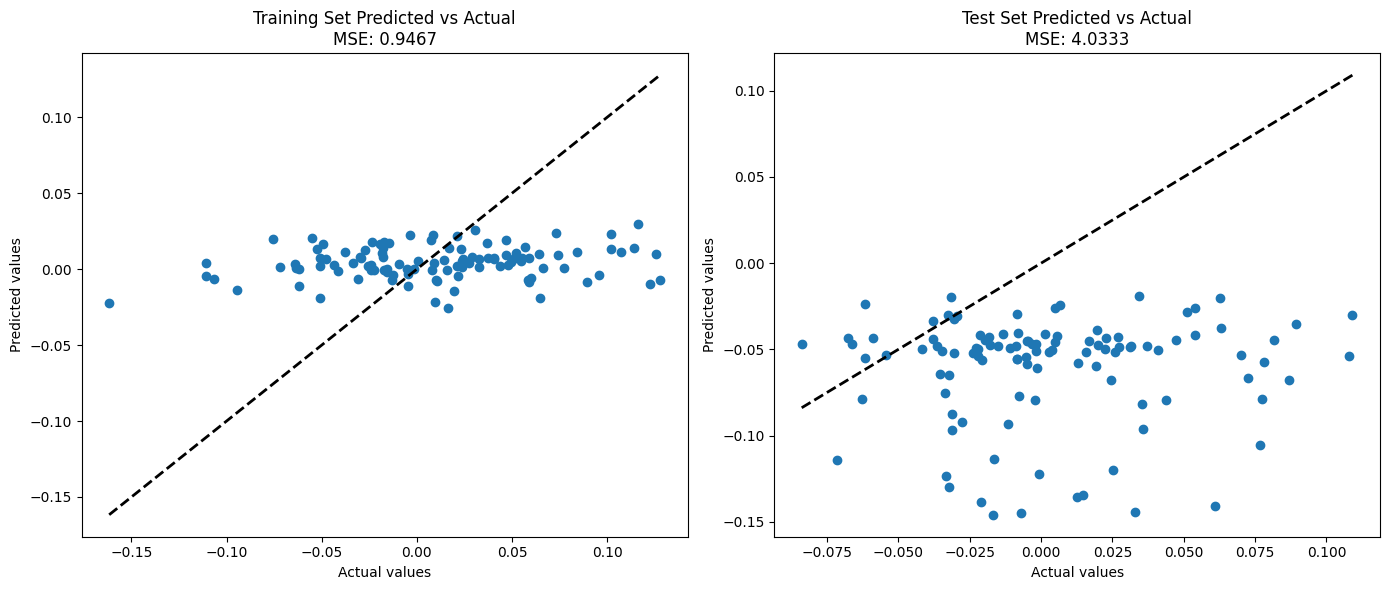

In [ ]:
# Get predictions for both training and test sets
train_sample = [get_predictions(train_loader, models[seed]) for seed in range(num_seeds)]
test_sample = [get_predictions(test_loader, models[seed]) for seed in range(num_seeds)]
train_targets = train_sample[0][0]

#
train_predictions = np.concatenate([train_sample[seed][1].reshape(-1, 1) for seed in range(num_seeds)], axis=1).mean(1)

test_targets = test_sample[0][0]
all_test_predictions = np.concatenate([test_sample[seed][1].reshape(-1, 1) for seed in range(num_seeds)], axis=1)
test_predictions = all_test_predictions.mean(1)

# Calculate MSE for both training and test sets
train_mse = np.mean((train_targets - train_predictions) ** 2) / np.mean(train_targets ** 2)
test_mse = np.mean((test_targets.reshape(-1, 1) - test_predictions) ** 2) / np.mean(test_targets ** 2)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Training set subplot
axs[0].scatter(train_targets, train_predictions)
axs[0].plot([train_targets.min(), train_targets.max()], [train_targets.min(), train_targets.max()], 'k--', lw=2)  # Diagonal line
axs[0].set_xlabel('Actual values')
axs[0].set_ylabel('Predicted values')
axs[0].set_title(f'Training Set Predicted vs Actual\nMSE: {train_mse:.4f}')

# Test set subplot
axs[1].scatter(test_targets, test_predictions)#.mean(1))
axs[1].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'k--', lw=2)  # Diagonal line
axs[1].set_xlabel('Actual values')
axs[1].set_ylabel('Predicted values')
axs[1].set_title(f'Test Set Predicted vs Actual\nMSE: {test_mse:.4f}')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, '0    0.26\n1   -0.20\ndtype: float32')

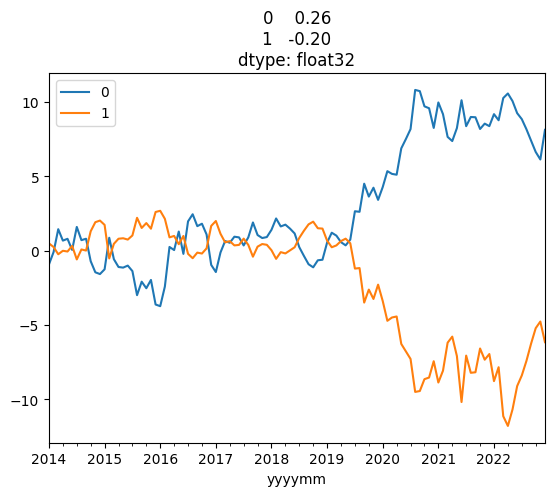

In [ ]:
# now I define R_{t+1} * pi_t
# test_predictions have 10 columns, each column corresponding to a different random seed
timed_returns = test_targets.reshape(-1, 1) * test_predictions.reshape(-1, 1)
together = pd.DataFrame(np.concatenate([test_targets.reshape(-1, 1), timed_returns], axis=1), index=test_dates)
(together / together.std()).cumsum().plot()
plt.title(f'{GoyalWelchData.sharpe_ratio(together)}')

In [ ]:
model = models[0]
model.eval()
train_data_predictions, train_data_features = model(X_train_tensor, return_last_hidden=True)
print(train_data_predictions.shape)
print(train_data_features.shape)

test_data_predictions, test_data_features = model(X_test_tensor, return_last_hidden=True)


torch.Size([108, 1])
torch.Size([108, 256])


In [ ]:
output_layer = list(model.layers)[-1]  # Get the last layer
# Now, access its weights and biases
weights = output_layer.weight.data
biases = output_layer.bias.data
print("Weights of the output layer:", weights)
print("Biases of the output layer:", biases)

Weights of the output layer: tensor([[-0.0743, -0.0679, -0.0351, -0.0413, -0.0111, -0.0601,  0.1004, -0.0523,
         -0.1189, -0.0393, -0.1252, -0.0196,  0.0058,  0.0279, -0.0397, -0.0394,
          0.0154,  0.0465, -0.0792,  0.0002,  0.0400, -0.0232,  0.0842, -0.0305,
         -0.0111, -0.0819, -0.0308, -0.1481, -0.2177,  0.0151, -0.0729,  0.0685,
         -0.0130,  0.0596,  0.0484,  0.0164, -0.0251, -0.0988, -0.0835, -0.0360,
          0.0444,  0.0821, -0.0109,  0.0307,  0.0259, -0.0506,  0.0007, -0.0663,
         -0.0510,  0.0403, -0.1007,  0.1769,  0.0272, -0.0674, -0.0273, -0.0526,
         -0.0414, -0.0591, -0.0522,  0.0176,  0.0058,  0.0559,  0.0268, -0.0218,
          0.0657,  0.0819, -0.0927,  0.0615,  0.0482,  0.0782, -0.0834,  0.0246,
          0.0321,  0.0630, -0.0089,  0.0488,  0.1104, -0.0038,  0.0135, -0.0966,
         -0.1032, -0.0194, -0.1018, -0.0117,  0.1155, -0.0646, -0.0709, -0.0938,
         -0.0246, -0.0407,  0.0198,  0.0145, -0.0255,  0.0266, -0.0888, -0.0268,

#Note that
$$
f(x)\ =\ \sum_{i=1}^n W_{3,i}h_i(x) +b_3\cdot 1
$$
#and hence, to re-produce the output of the neural net, we need to add an "additional" feature equal to 1. We do this using torch.ones([train_data_features.shape[0], 1])

In [ ]:
new_X_train = torch.concatenate([train_data_features, torch.ones([train_data_features.shape[0], 1])], axis=1)
new_X_test = torch.concatenate([test_data_features, torch.ones([test_data_features.shape[0], 1])], axis=1)


In [ ]:
shrinkage_list = [0.00000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
beta_estimate_using_train_sample, oos_predictions = ridge_regr(signals=new_X_train.detach().numpy(),
                                                                labels=y_train,
                                                                future_signals=new_X_test.detach().numpy(),
                                                                shrinkage_list=shrinkage_list)


In [ ]:
fine_tuned_mse = np.mean((test_targets.reshape(-1, 1) - oos_predictions) ** 2, axis=0) / np.mean((test_targets) ** 2)
print(fine_tuned_mse)

[37.43146055 32.74470939 24.40453947 12.16546485  3.56363838  1.27118991
  0.99499155  0.99516716  0.99854968  0.99983656]


Text(0.5, 1.0, '0     0.26\n1     0.66\n2     0.24\n3    -0.05\n4    -0.16\n5    -0.16\n6    -0.13\n7     0.28\n8     0.25\n9     0.24\n10    0.24\ndtype: float64')

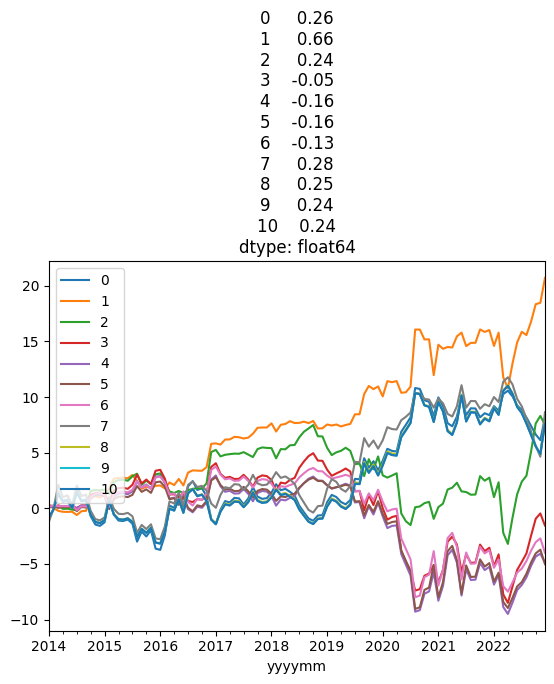

In [ ]:
timed_returns = test_targets.reshape(-1, 1) * oos_predictions
together = pd.DataFrame(np.concatenate([test_targets.reshape(-1, 1), timed_returns], axis=1), index=test_dates)
(together / together.std()).cumsum().plot()
plt.title(f'{GoyalWelchData.sharpe_ratio(together)}')